In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

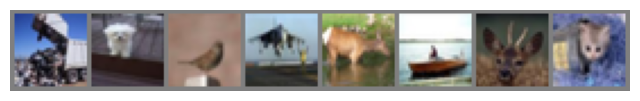

truck dog bird airplane deer ship deer cat
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations to preprocess the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

# 5. Show some images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

print(images.shape, labels.shape)


[1,   100] loss: 1.834
[1,   200] loss: 1.486
[1,   300] loss: 1.362
[1,   400] loss: 1.281
[1,   500] loss: 1.219
[1,   600] loss: 1.148
[1,   700] loss: 1.127
Epoch 1 average loss: 1.3214
[2,   100] loss: 1.003
[2,   200] loss: 0.958
[2,   300] loss: 0.965
[2,   400] loss: 0.926
[2,   500] loss: 0.932
[2,   600] loss: 0.897
[2,   700] loss: 0.906
Epoch 2 average loss: 0.9340
[3,   100] loss: 0.775
[3,   200] loss: 0.788
[3,   300] loss: 0.762
[3,   400] loss: 0.766
[3,   500] loss: 0.779
[3,   600] loss: 0.761
[3,   700] loss: 0.744
Epoch 3 average loss: 0.7645
[4,   100] loss: 0.615
[4,   200] loss: 0.624
[4,   300] loss: 0.622
[4,   400] loss: 0.638
[4,   500] loss: 0.618
[4,   600] loss: 0.634
[4,   700] loss: 0.622
Epoch 4 average loss: 0.6267
[5,   100] loss: 0.493
[5,   200] loss: 0.471
[5,   300] loss: 0.502
[5,   400] loss: 0.474
[5,   500] loss: 0.515
[5,   600] loss: 0.518
[5,   700] loss: 0.504
Epoch 5 average loss: 0.4997


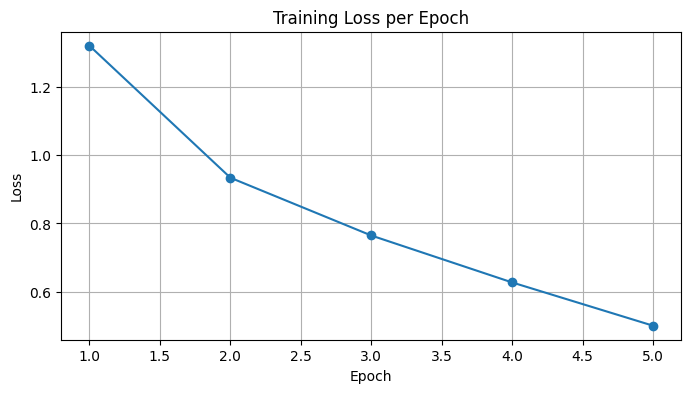

In [4]:
# Define a simple CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# 7. Instantiate model, loss and optimizer
net = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 8. Training loop
epochs = 5
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    net.train()

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    avg_loss = epoch_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [5]:
# Calculate total number of trainable parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(net)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Display model summary
print(f"\nModel architecture:")
print(net)

Total parameters: 1,070,794
Trainable parameters: 1,070,794

Model architecture:
SmallCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


Accuracy on test set: 72.15%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.73      0.76      1000
  automobile       0.84      0.82      0.83      1000
        bird       0.58      0.65      0.62      1000
         cat       0.58      0.50      0.53      1000
        deer       0.67      0.66      0.67      1000
         dog       0.72      0.54      0.62      1000
        frog       0.64      0.88      0.74      1000
       horse       0.78      0.80      0.79      1000
        ship       0.81      0.85      0.83      1000
       truck       0.81      0.79      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



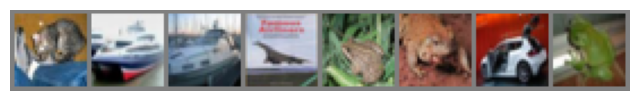

Predicted: cat ship airplane airplane frog frog automobile frog
Actual:    cat ship ship airplane frog frog automobile frog


In [12]:
# Evaluation on test set

net.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Visualize some predictions
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8].cpu()))
print("Predicted:", ' '.join(f'{classes[predicted[j]]}' for j in range(8)))
print("Actual:   ", ' '.join(f'{classes[labels[j]]}' for j in range(8)))

<Figure size 1000x800 with 0 Axes>

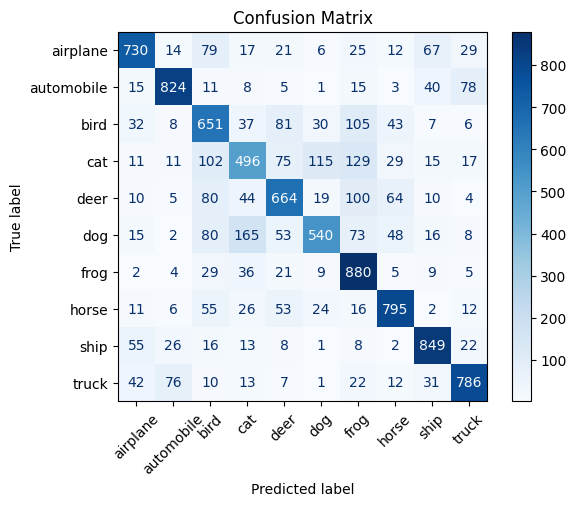

In [13]:
# Confusion matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()